In [ ]:
from sklearn import linear_model
import numpy as np
import os

import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
StepSize = 10 # how many output steps to predict over

In [ ]:
DIR = '/data/oceans_output/open/racfur'
exp_list = ['4500yr_Windx0.50']
file_list =[]
for exp in exp_list:
    for filename in os.listdir(os.path.join(DIR,exp)):
        if filename.__contains__('cat'):
            file_list.append(os.path.join(DIR,exp,filename))

print(file_list)

In [5]:
#print(file_list[0])
ds   = xr.open_dataset(file_list[0])

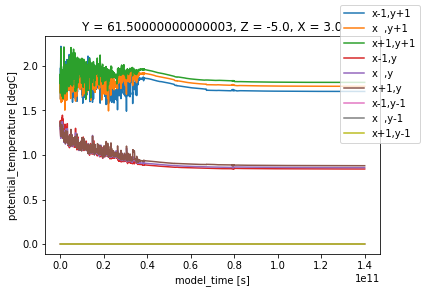

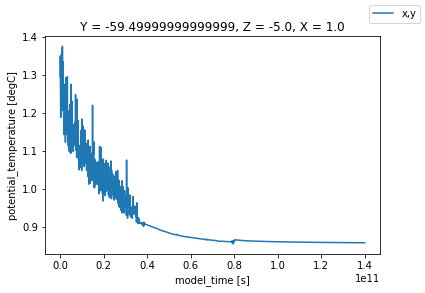

In [6]:
#Plot a timeseries of the various potential inputs 
# here plotting for a single grid cell. Plotting Temp for set grid point and 
# an 8 cell halo. Aim is to use this to predict Temp at a later time step

z_level=0
lat=0  # actually x point (11 points in x dir)
lon=0  # actually y point (78 points in y dir)

fig1 = plt.figure()

ds.Temp.isel(X=lat-1,Y=lon+1,Z=z_level  ).plot(label=('x-1,y+1'))
ds.Temp.isel(X=lat  ,Y=lon+1,Z=z_level  ).plot(label=('x  ,y+1'))
ds.Temp.isel(X=lat+1,Y=lon+1,Z=z_level  ).plot(label=('x+1,y+1'))
ds.Temp.isel(X=lat-1,Y=lon  ,Z=z_level  ).plot(label=('x-1,y  '))
ds.Temp.isel(X=lat  ,Y=lon  ,Z=z_level  ).plot(label=('x  ,y  '))
ds.Temp.isel(X=lat+1,Y=lon  ,Z=z_level  ).plot(label=('x+1,y  '))
ds.Temp.isel(X=lat-1,Y=lon-1,Z=z_level  ).plot(label=('x-1,y-1'))
ds.Temp.isel(X=lat  ,Y=lon-1,Z=z_level  ).plot(label=('x  ,y-1'))
ds.Temp.isel(X=lat+1,Y=lon-1,Z=z_level  ).plot(label=('x+1,y-1'))

fig1.legend()

fig2 = plt.figure()
ds.Temp.isel(X=lat,Y=lon,Z=z_level).plot(label=('x,y'))
fig2.legend()

In [7]:
inputs = []
outputs = []

z=0 #just look at surface for now
for x in range(0,10,3):
    for y in range(0,77,3):
        for time in range(0, len(ds.T.data)-StepSize, 40):
            inputs.append([ds.Temp.isel(T=time,X=x-1,Y=y+1,Z=z),
                           ds.Temp.isel(T=time,X=x  ,Y=y+1,Z=z),
                           ds.Temp.isel(T=time,X=x+1,Y=y+1,Z=z),
                           ds.Temp.isel(T=time,X=x-1,Y=y  ,Z=z),
                           ds.Temp.isel(T=time,X=x  ,Y=y  ,Z=z),
                           ds.Temp.isel(T=time,X=x+1,Y=y  ,Z=z),
                           ds.Temp.isel(T=time,X=x-1,Y=y-1,Z=z),
                           ds.Temp.isel(T=time,X=x  ,Y=y-1,Z=z),
                           ds.Temp.isel(T=time,X=x+1,Y=y-1,Z=z)])
            outputs.append([ds.Temp.isel(T=time+StepSize,X=x,Y=y,Z=z)])
    
inputs=np.asarray(inputs)
outputs=np.asarray(outputs)

inputs_keep=inputs
outputs_keep=outputs

print(inputs.shape)
print(outputs.shape)

(140400, 9)
(140400, 1)


In [8]:
#Split data into training and test data
split_ind = 100000 # change this to something based on model time eventually
inputs_tr, inputs_te = inputs[:split_ind, :], inputs[split_ind:, :]
outputs_tr, outputs_te = outputs[:split_ind], outputs[split_ind:]

print(inputs_tr.shape, inputs_te.shape)
print(outputs_tr.shape, outputs_te.shape)

(100000, 9) (40400, 9)
(100000, 1) (40400, 1)


In [9]:
### Normalise (based on training data only)
def normalise_data(train,test):
    train_mean, train_std = np.mean(train), np.std(train)
    train = (train - train_mean) / train_std
    test  = (test - train_mean) / train_std
    return train, test

# Calc mean and std for re-forming predictions
outputs_tr_mean = np.mean(outputs)
outputs_tr_std = np.std(outputs)
print(outputs_tr_mean, outputs_tr_std)

# normalise the data
outputs_tr[:], outputs_te[:] = normalise_data(outputs_tr[:], outputs_te[:])
for i in range(3):
    inputs_tr[:, i], inputs_te[:, i] = normalise_data(inputs_tr[:, i], inputs_te[:, i])

17.92383 8.943233


In [10]:
# Fit a model....

model= linear_model.Lasso(alpha=0.1)

model.fit(inputs,outputs)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
print(model.coef_)
print(model.intercept_)

[0.         0.         0.         0.         0.10731667 0.
 0.         0.00361016 0.        ]
[-2.0410316]


In [12]:
predict = model.predict([[35,35,35,35,35,35,35,35,35]])
print(predict)

predict = model.predict([[1,1,1,1,1,1,1,1,1]])
print(predict)

[1.84140768]
[-1.93010476]


In [13]:
# how to evaluate test stats....?
model.score(inputs_te, outputs_te)  

0.9998531915142492